In [2]:
from utils.binaries import *
from utils.plotting import *

07:30:50 ( +636.1s) [INFO   ] -- import logging
07:30:51 (  +150ms) [INFO   ] -- import numpy as np
07:30:51 (    +5ms) [INFO   ] -- import uncertainties
07:30:51 (  +202ms) [INFO   ] -- import pandas as pd
07:30:51 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
07:30:51 (    +2ms) [INFO   ] -- import binaries.tools as tools
07:30:51 (  +283ms) [INFO   ] -- import matplotlib.pyplot as plt
07:30:51 (  +391ms) [INFO   ] -- import seaborn as so
07:30:51 (    +2ms) [INFO   ] -- import plotting.tools as plot
07:30:51 (    +6ms) [DEBUG  ] -- font size set to 9.5
07:30:51 (    +1ms) [DEBUG  ] -- label size set to 13.0
07:30:51 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
07:30:51 (    +1ms) [DEBUG  ] -- markersize set to 2.0
07:30:51 (    +1ms) [DEBUG  ] -- usetex set to False


In [3]:
from scipy.optimize import curve_fit
import os

def parabola(x, a, mip, height):
    return a*(x - mip)**2 + height

def get_signal(peak_histo, station):

    extract = {
        '643' : lambda x : x[np.argmax(peak_histo)-10 : np.argmax(peak_histo) + 10],
        '659' : lambda x : x[np.argmax(peak_histo)-10 : np.argmax(peak_histo) + 10],
        '660' : lambda x : x[np.argmax(peak_histo[2:])-10 : np.argmax(peak_histo[2:]) + 10],
        '1823' : lambda x : x[np.argmax(peak_histo)-10 : np.argmax(peak_histo) + 10],
        '1840' : lambda x : x[np.argmax(peak_histo)-10 : np.argmax(peak_histo) + 10],
        '1844' : lambda x : x[np.argmax(peak_histo)-10 : np.argmax(peak_histo) + 10],
        '1845' : lambda x : x[np.argmax(peak_histo)-10 : np.argmax(peak_histo) + 10],
        '1839' : lambda x : x[np.argmax(peak_histo)-10 : np.argmax(peak_histo) + 10],
    }

    return extract[station]

def read_file(path, directory):

    path = f'/cr/data01/filip/Data/muonAcquisition/{directory}/' + path
    all_hist = lambda x : [int(e.split(' ')[-1]) for e in x]
    coinc_hist = lambda x : [int(e.split(' ')[-4]) for e in x] # ...
    peak_histo, rates = [], []

    with open(path, 'r') as source:

        baseline = 0

        is_peak_histogram = False
        is_all_histogram = False
        for i, line in enumerate(source.readlines()):
            line = line.strip()

            if line.startswith('Offset'):
                baseline = int(line.split(' ')[-1])

            if line == 'Peak': 
                is_peak_histogram = True
                continue
            elif line == 'Charge':
                is_peak_histogram = False
            
            if is_peak_histogram: peak_histo.append(line)
            if line == '======ssd:':
                is_all_histogram = True
                continue

            if is_all_histogram: rates.append(line)
            
        bin0 = int(rates[0].split(' ')[3])

        ADC_bin_edges = np.array([2*k for k in range(100)] + [200 + 8*k for k in range(51)])
        x_peak_histo = 0.5 * (ADC_bin_edges[1:] + ADC_bin_edges[:-1])
        peak_histo = np.array(coinc_hist(peak_histo))


        signal = get_signal(peak_histo, path.split('_')[1])
        (curve, mip, height), pcov = curve_fit(parabola, signal(x_peak_histo), signal(peak_histo),
                                bounds=([-np.inf, 0, 0],[0, np.inf, np.inf]),
                                maxfev=10000,
                                p0=[-1, 50, 2000])

    return peak_histo, np.cumsum(all_hist(rates[1:])[::-1])[::-1] / 60, bin0 - baseline, mip

In [4]:
rate_mip, mean_rate = np.loadtxt('/cr/data01/filip/Data/muonAcquisition/mean_rates.txt', unpack=True)
online_predictions = {}

for directory in ['day', 'night']:
    files = os.listdir(f'/cr/data01/filip/Data/muonAcquisition/{directory}/')

    for file in files:
        timestamp, station = file.split('_')

        try:
            _, rates, offset, mip = read_file(file, directory)
        except ValueError as e:
            print(directory, file, e)

        try:
            _ = online_predictions[station]
        except KeyError:
            online_predictions[station] = []

        adc_thresholds_for_prediction = np.arange(offset, offset + len(rates) + 0.1, 1)

        this_prediction = []
        for _bin, r in zip(adc_thresholds_for_prediction, rates):
            histogram_factor = rate_mip[np.argmin(np.abs(r - mean_rate))]
            online_mip = _bin / histogram_factor

            this_prediction.append((online_mip - mip) / mip)

        online_predictions[station].append(this_prediction)


day 1713986545_660 operands could not be broadcast together with shapes (11,) (20,) 
day 1713986547_1845 operands could not be broadcast together with shapes (0,) (20,) 
day 1713986548_643 operands could not be broadcast together with shapes (0,) (20,) 
day 1713986549_659 operands could not be broadcast together with shapes (0,) (20,) 
day 1713986549_1844 operands could not be broadcast together with shapes (0,) (20,) 
day 1713986804_643 operands could not be broadcast together with shapes (0,) (20,) 
day 1713986804_659 operands could not be broadcast together with shapes (0,) (20,) 
day 1713986804_660 operands could not be broadcast together with shapes (11,) (20,) 
day 1713986804_1844 operands could not be broadcast together with shapes (0,) (20,) 
day 1713986804_1845 operands could not be broadcast together with shapes (0,) (20,) 


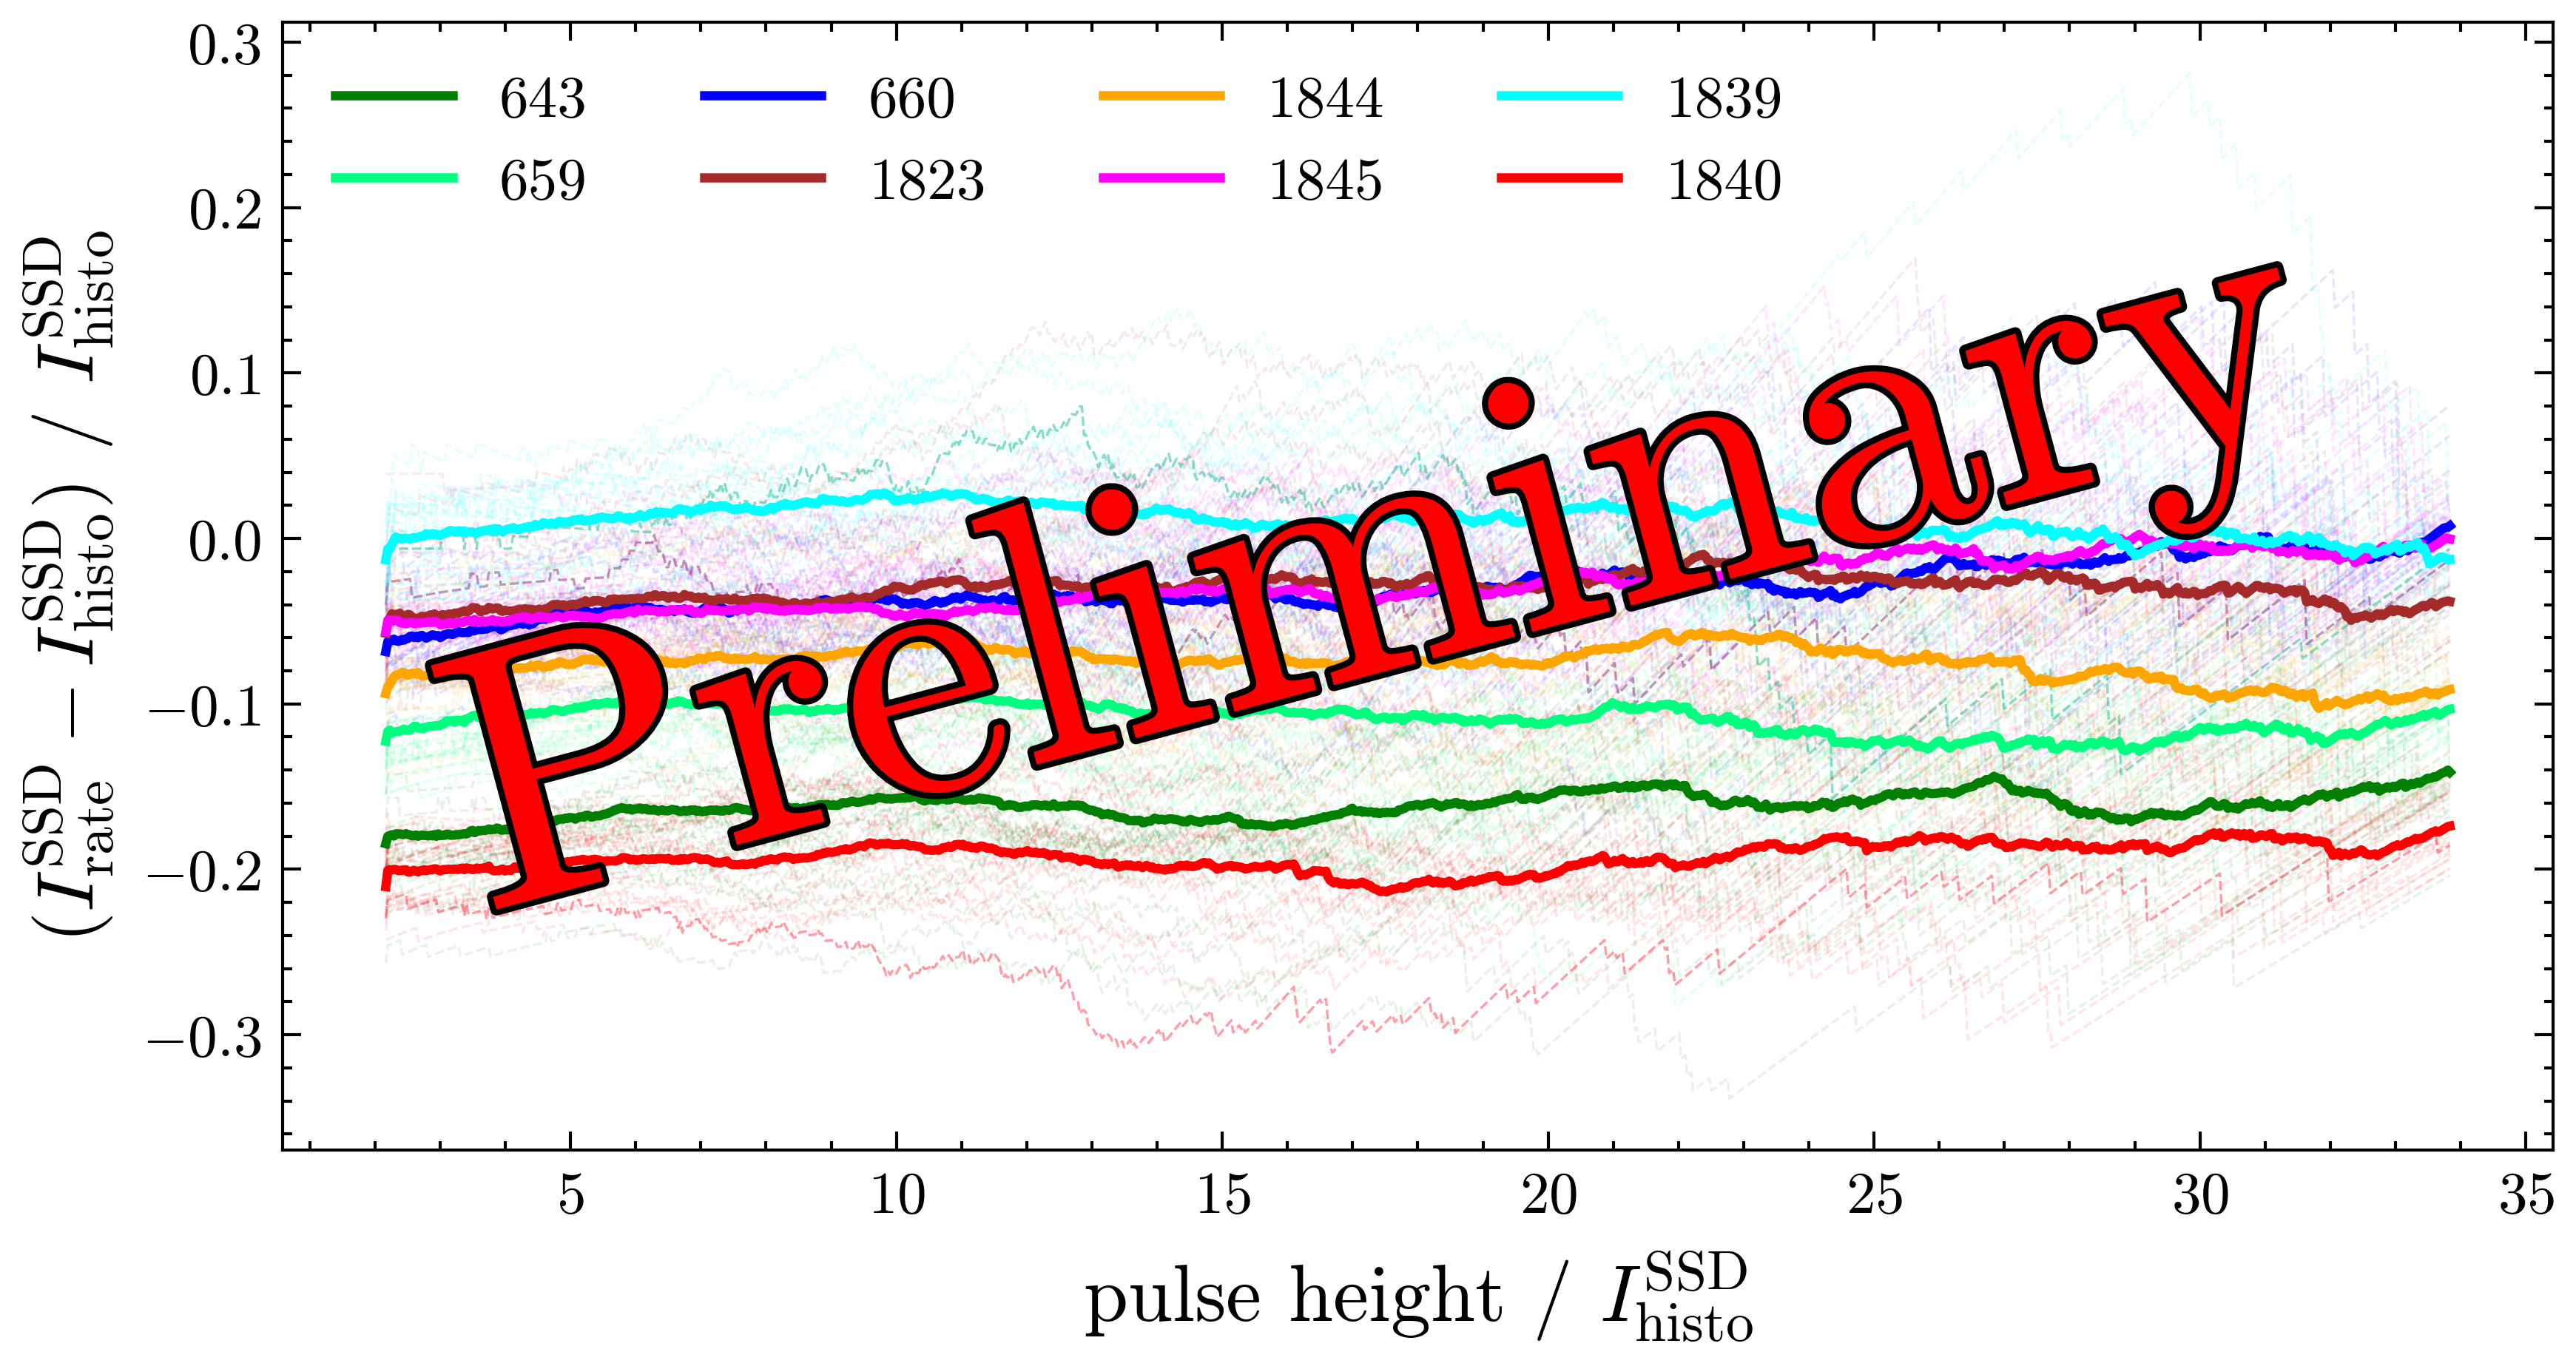

In [5]:
colors = {
    '643' : 'green',
    '1840' : 'red',
    '659' : 'springgreen',
    '660' : 'blue',
    '1823' : 'brown',
    '1844' : 'orange',
    '1845' : 'magenta',
    '1839' : 'cyan'
}

for station, predictions in online_predictions.items():
    
    color = colors[station]
    mean_prediction = np.zeros(len(mean_rate))
    for prediction in predictions:
        mean_prediction += 1/len(predictions) * np.array(prediction)
        plt.plot(rate_mip, prediction, c=color, ls='--', lw=0.4, alpha=0.1, zorder=5)

    plt.plot(rate_mip, mean_prediction, c=color, lw=1.5, label=station, ls='solid', zorder=10)

plt.legend(ncol=4)

plt.xlabel('pulse height / $I^\mathrm{SSD}_\mathrm{histo}$')
plt.ylabel('$(I^\mathrm{SSD}_\mathrm{rate} - I^\mathrm{SSD}_\mathrm{histo})$ / $I^\mathrm{SSD}_\mathrm{histo}$')
plot.preliminary(plt.gcf())